In [1]:
import os.path

import matplotlib.pyplot as plt
import numpy as np

In [2]:
RAW_DIR = "/hao/sunrise/Data/KCor/raw/2018/20181203/stream_data/184832raw"

do_display = True

In [3]:
clist = 'imlist'

nx       = 1024
ny       = 1024
n_frames = 495

In [4]:
states   = np.zeros((nx, ny, n_frames, 4), dtype=np.float32)

avgall   = np.zeros((nx, ny), dtype=np.float64)

In [5]:
%%time
with open(os.path.join(RAW_DIR, clist), "r") as f:
    filenames = [line.rstrip() for line in f.readlines()]

n_states = 4
for f in range(n_frames):
    for s in range(n_states):
        with open(os.path.join(RAW_DIR, filenames[n_states * f + s]), "r") as bf:
            im = np.fromfile(bf, dtype=np.int16).reshape((nx, ny))
        states[:, :, f, s] = im.astype(np.float32)

singleimg = np.sqrt((states[:, :, :, 0] - states[:, :, :, 3]) ** 2
                        + (states[:, :, :, 1] - states[:, :, :, 2]) ** 2)

CPU times: user 25.7 s, sys: 8.21 s, total: 33.9 s
Wall time: 1min 13s


In [6]:
%%time
states_mean = np.mean(states[:, :, :, :], axis=2)
states_median = np.median(states[:, :, :, :], axis=2)

CPU times: user 33.1 s, sys: 10 s, total: 43.1 s
Wall time: 3min 35s


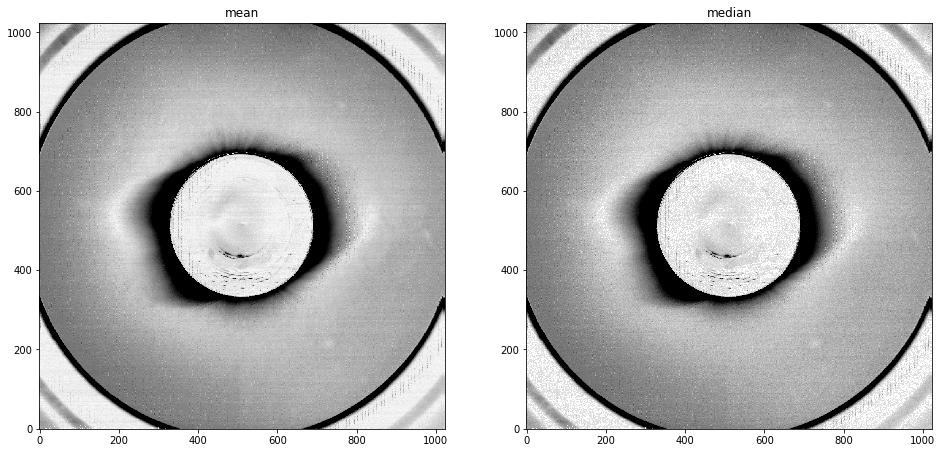

In [7]:
if do_display:
    size = 8
    cmap = "Greys"
    #cmap = "viridis"
    d_min = 0.0
    d_max = 5.0
    d_exp = 0.5
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*size, size))
    
    corona_mean = np.sqrt((states_mean[:, :, 0] - states_mean[:, :, 3])**2 + (states_mean[:, :, 1] - states_mean[:, :, 2])**2)
    ax1.imshow(corona_mean**d_exp, vmin=d_min, vmax=d_max, cmap=cmap, origin="lower")
    ax1.set_title("mean")
    
    corona_median = np.sqrt((states_median[:, :, 0] - states_median[:, :, 3])**2 + (states_median[:, :, 2] - states_median[:, :, 1])**2)
    ax2.imshow(corona_median**d_exp, vmin=d_min, vmax=d_max, cmap=cmap, origin="lower")
    ax2.set_title("median")

In [8]:
newstates = np.zeros((nx, ny, 4), dtype=np.float32)
masks = np.zeros((nx, ny, 4), dtype=np.int32)

ss = 4.0 / 44.0
threshold = n_frames * 0.90

In [9]:
%%time
for j in range(nx):
    for i in range(ny):
        for s in range(n_states):
            indices = np.where(np.abs(states[i, j, :, s] - states_median[i, j, s]) < ss * np.sqrt(states_median[i, j, s] * 44.0))
            n = indices[0].size
            if n > threshold:
                newstates[i, j, s] = np.mean(states[i, j, indices, s])
            else:
                newstates[i, j, s] = states_mean[i, j, s]
            masks[i, j, s] = n

CPU times: user 3min 25s, sys: 5.3 s, total: 3min 30s
Wall time: 17min 28s


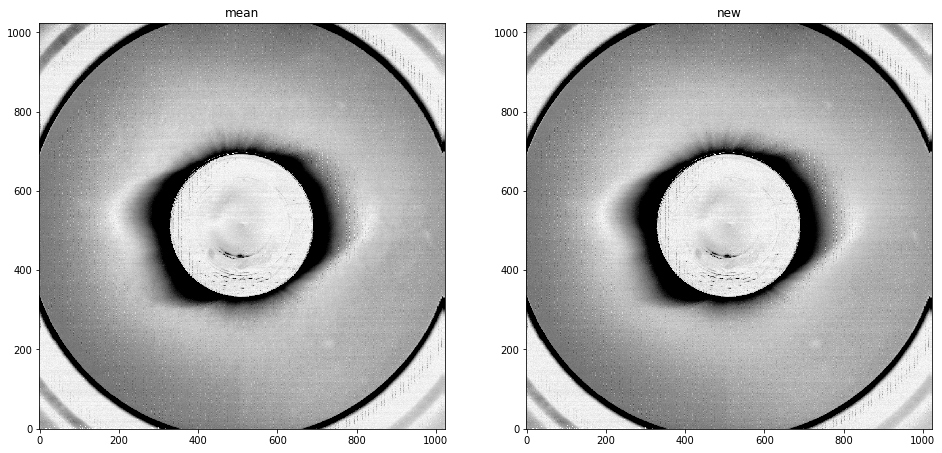

In [10]:
if do_display:
    size = 8
    cmap = "Greys"
    #cmap = "viridis"                                                                        

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*size, size))

    corona_mean = np.sqrt((states_mean[:, :, 0] - states_mean[:, :, 3])**2 + (states_mean[:, :, 2] - states_mean[:, :, 1])**2)
    ax1.imshow(corona_mean**d_exp, vmin=d_min, vmax=d_max, cmap=cmap, origin="lower")
    ax1.set_title("mean")

    corona_new  = np.sqrt((newstates[:, :, 0] - newstates[:, :, 3])**2 + (newstates[:, :, 2] - newstates[:, :, 1])**2)
    ax2.imshow(corona_new**d_exp, vmin=d_min, vmax=d_max, cmap=cmap, origin="lower")
    ax2.set_title("new")

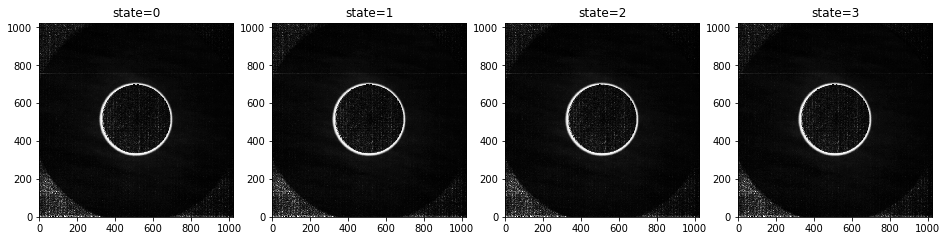

In [11]:
if do_display:
    size = 4
    cmap = "Greys"
    #cmap = "viridis"                                                                        

    f, axes = plt.subplots(1, 4, figsize=(4*size, size))
    for p, ax in enumerate(axes):
        ax.imshow(masks[:, :, p], cmap=cmap, origin="lower")
        ax.set_title(f"state={p}")